# NLP Practical
#### Roll No: 702

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import re
from string import punctuation
from collections import Counter

#!pip install unidecode
from unidecode import unidecode

#!pip install textblob
from textblob import TextBlob

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

import nltk
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
#Reading Data
df = pd.read_csv(r"C:\Users\shahv\Downloads\Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#Colab
#from google.colab import files
#uploaded = files.upload()

In [ ]:
#import io
#import pandas as pd
#df = pd.read_csv(io.BytesIO(uploaded['Tweets.csv']))

## Q1A. Data Cleaning/Pre-processing

In [3]:
stop_words = stopwords.words('english')
punct = list(punctuation)
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [4]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [5]:
def pre_process(tweet):
    tweet=unidecode(tweet)
    tweet=tweet.lower()
    tweet = re.sub(r'\d+', '', tweet)
    tokens = word_tokenize(tweet)
    tokens=[i for i in tokens if i.isalpha()]
    cleaned_tokens = [token for token in tokens if token not in stop_words ]

    #stems=[ps.stem(token) for token in cleaned_tokens]
    tags=nltk.pos_tag(cleaned_tokens)
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), tags))

    lemmatized=[]
    for word in wordnet_tagged:
        if word[1]!=None:
            lemmatized.append(lemmatizer.lemmatize(word[0],word[1]))
        else:
            lemmatized.append(lemmatizer.lemmatize(word[0]))
    return " ".join(lemmatized)

In [6]:
pre_process(df["text"][19])

'virginamerica know would amazingly awesome please want fly'

In [7]:
df["cleaned_tweets"]=df["text"].map(lambda x: pre_process(x))

In [8]:
df["cleaned_tweets"]

0                               virginamerica dhepburn say
1        virginamerica plus added commercial experience...
2        virginamerica today must mean need take anothe...
3        virginamerica really aggressive blast obnoxiou...
4                       virginamerica really big bad thing
                               ...                        
14635       americanair thank get different flight chicago
14636    americanair leave minute late flight warning c...
14637    americanair please bring american airline blac...
14638    americanair money change flight answer phone s...
14639    americanair ppl need know many seat next fligh...
Name: cleaned_tweets, Length: 14640, dtype: object

## Q1B. Word Cloud

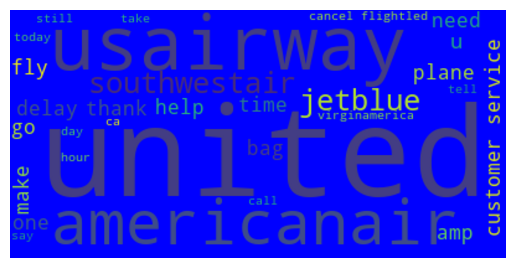

In [9]:
#Combining all the reviews
text = " ".join(review for review in df.cleaned_tweets)

#Create stopword list
stop_words =  set(STOPWORDS)
stop_words.update(['flight', 'airline'])

#Generate a wordcloud image
wordcloud = WordCloud(mode = 'RGBA', max_font_size = 100, stopwords = stop_words, max_words = 30, 
                      background_color = 'blue').generate(text)

#Display the generated image the matplotlib way
plt.imshow(wordcloud, interpolation = 'mitchell')
plt.axis('off')
plt.show()

## Q1C. Afinn Algorithm

In [10]:
def sentiment_score(df):
    def getSubjectivity(text):
        return TextBlob(text).sentiment.subjectivity
    
    #Create a function to get the polarity
    def getPolarity(text):
        return TextBlob(text).sentiment.polarity

    #Create two new columns ‘Subjectivity’ & ‘Polarity’
    df['subjectivity'] = df['cleaned_tweets'].apply(getSubjectivity)
    df['polarity'] = df['cleaned_tweets'].apply(getPolarity)
    
    def classify(score):
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'
    
    df['classfication'] = df['polarity'].apply(classify)
    
    return df

In [11]:
sentiment_score(df)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweets,subjectivity,polarity,classfication
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),virginamerica dhepburn say,0.000000,0.000000,Neutral
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),virginamerica plus added commercial experience...,0.000000,0.000000,Neutral
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),virginamerica today must mean need take anothe...,0.687500,-0.312500,Negative
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),virginamerica really aggressive blast obnoxiou...,0.350000,0.006250,Positive
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),virginamerica really big bad thing,0.383333,-0.350000,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN,americanair thank get different flight chicago,0.600000,0.000000,Neutral
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN,americanair leave minute late flight warning c...,0.600000,-0.300000,Negative
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN,americanair please bring american airline blac...,0.000000,0.000000,Neutral
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada),americanair money change flight answer phone s...,0.000000,0.000000,Neutral


## Q2A. Hypernyms & Hyponyms

In [12]:
def abstractterm(word):
    syn = wordnet.synsets(word)[0]
    return (syn.hypernyms()[0]).lemma_names()[0]

def specificterm(word):
    syn = wordnet.synsets(word)[0]
    ls = list(set([w for s in syn.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))[0]
    return ls

In [13]:
specificterm('flower')

'Rudbeckia_laciniata'

## Q2B. Jaccard Similarity

In [14]:
sent1 = "The glass is empty"
sent2 = "There is nothing in the glass"

In [15]:
def get_jaccard_sim(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [16]:
get_jaccard_sim(sent1.lower(), sent2.lower())

0.42857142857142855

## Q2C. Cosine Similarity

In [17]:
def get_vectors(*strs):
    text = [t for t in strs]
    print(text)
    vect = CountVectorizer()
    vect.fit(text)
    return vect.transform(text).toarray()

In [18]:
def get_cosine_sim(*strs):
    vectors = [t for t in get_vectors(*strs)]
    return cosine_similarity(vectors)

In [19]:
get_cosine_sim(sent1,sent2)

['The glass is empty', 'There is nothing in the glass']


array([[1.        , 0.61237244],
       [0.61237244, 1.        ]])

## Q3. Sentiment Analysis

##### Data Cleaning

In [20]:
df = pd.read_csv(r"C:\Users\shahv\Downloads\Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [21]:
stop_words = stopwords.words('english')
punct = list(punctuation)
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [22]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [23]:
def pre_process(tweet):
    tweet=unidecode(tweet)
    tweet=tweet.lower()
    tweet = re.sub(r'\d+', '', tweet)
    tokens = word_tokenize(tweet)
    tokens=[i for i in tokens if i.isalpha()]
    cleaned_tokens = [token for token in tokens if token not in stop_words ]

    #stems=[ps.stem(token) for token in cleaned_tokens]
    tags=nltk.pos_tag(cleaned_tokens)
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), tags))

    lemmatized=[]
    for word in wordnet_tagged:
        if word[1]!=None:
            lemmatized.append(lemmatizer.lemmatize(word[0],word[1]))
        else:
            lemmatized.append(lemmatizer.lemmatize(word[0]))
    return " ".join(lemmatized)

In [24]:
df["cleaned_tweets"]=df["text"].map(lambda x: pre_process(x))
df["cleaned_tweets"]

0                               virginamerica dhepburn say
1        virginamerica plus added commercial experience...
2        virginamerica today must mean need take anothe...
3        virginamerica really aggressive blast obnoxiou...
4                       virginamerica really big bad thing
                               ...                        
14635       americanair thank get different flight chicago
14636    americanair leave minute late flight warning c...
14637    americanair please bring american airline blac...
14638    americanair money change flight answer phone s...
14639    americanair ppl need know many seat next fligh...
Name: cleaned_tweets, Length: 14640, dtype: object

##### Splitting into train and test datasets

In [25]:
X_train,X_test,Y_train, Y_test = train_test_split(df['cleaned_tweets'], df['airline_sentiment'], test_size=0.25, random_state=30)
print("Train: ",X_train.shape,Y_train.shape,"Test: ",(X_test.shape,Y_test.shape))

Train:  (10980,) (10980,) Test:  ((3660,), (3660,))


##### Word Embedding using TF-IDF

In [26]:
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

##### Word Embedding using Bag of Words

In [27]:
vectorizer = CountVectorizer()
bow_x_train = vectorizer.fit_transform(X_train)
bow_x_test = vectorizer.transform(X_test)

##### Building machine learning model using Logistic Regression

In [28]:
#Using TF-IDF Vectorizer
clf = LogisticRegression(max_iter=1000,solver='saga')

#Training the model
clf.fit(tf_x_train,Y_train)

#Predicting results
y_test_pred=clf.predict(tf_x_test)

#Analysing Results
classification_report(Y_test, y_test_pred,output_dict=True)

{'negative': {'precision': 0.8115399025852379,
  'recall': 0.9388816644993498,
  'f1-score': 0.8705787781350482,
  'support': 2307},
 'neutral': {'precision': 0.6706484641638225,
  'recall': 0.5057915057915058,
  'f1-score': 0.5766691122523845,
  'support': 777},
 'positive': {'precision': 0.8074074074074075,
  'recall': 0.5677083333333334,
  'f1-score': 0.6666666666666667,
  'support': 576},
 'accuracy': 0.7885245901639344,
 'macro avg': {'precision': 0.7631985913854892,
  'recall': 0.6707938345413963,
  'f1-score': 0.7046381856846997,
  'support': 3660},
 'weighted avg': {'precision': 0.7809789832202461,
  'recall': 0.7885245901639344,
  'f1-score': 0.7760921151305079,
  'support': 3660}}

In [29]:
#Using BOW Vectorizer
clf = LogisticRegression(max_iter=1000,solver='saga')

#Training the model
clf.fit(bow_x_train,Y_train)

#Predicting results
y_test_pred=clf.predict(bow_x_test)

#Analysing results
classification_report(Y_test, y_test_pred,output_dict=True)

{'negative': {'precision': 0.8474784747847478,
  'recall': 0.8959687906371911,
  'f1-score': 0.8710493046776233,
  'support': 2307},
 'neutral': {'precision': 0.6197771587743732,
  'recall': 0.5727155727155727,
  'f1-score': 0.5953177257525083,
  'support': 777},
 'positive': {'precision': 0.7475149105367793,
  'recall': 0.6527777777777778,
  'f1-score': 0.6969416126042631,
  'support': 576},
 'accuracy': 0.7890710382513662,
 'macro avg': {'precision': 0.7382568480319668,
  'recall': 0.7071540470435139,
  'f1-score': 0.7211028810114649,
  'support': 3660},
 'weighted avg': {'precision': 0.7834066344713897,
  'recall': 0.7890710382513662,
  'f1-score': 0.7851122917106643,
  'support': 3660}}

#### We can see that TF-IDF provides better accuracy for all except negative values. TF-IDF also computes more than just the count of the words due to which it proves to be a better word embedding technique.

## Topic Modelling

In [30]:
df = pd.read_csv(r"C:\Users\shahv\Downloads\Tweets.csv")
df = df.head(200)
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,569282249717194754,negative,1.0000,Cancelled Flight,1.0000,Virgin America,NaN,FiDiFamilies,NaN,0,@VirginAmerica Because we never rec'd Cancelle...,NaN,2015-02-21 15:47:19 -0800,New York City,Eastern Time (US & Canada)
196,569277854950817792,negative,1.0000,Flight Booking Problems,1.0000,Virgin America,NaN,lexiesalas,NaN,0,@VirginAmerica trying to book a flight &amp; y...,NaN,2015-02-21 15:29:51 -0800,BAYAREA✈️NYC,Pacific Time (US & Canada)
197,569277352129138688,negative,0.7158,Cancelled Flight,0.7158,Virgin America,NaN,Artenis15,NaN,0,@VirginAmerica You have any flights flying int...,NaN,2015-02-21 15:27:52 -0800,MA // Ashton in Wonderland,Eastern Time (US & Canada)
198,569263837448269826,negative,1.0000,Cancelled Flight,1.0000,Virgin America,NaN,NancyJFriedman,NaN,0,@VirginAmerica you stink. Flight Cancelled Fli...,NaN,2015-02-21 14:34:09 -0800,New York City,Eastern Time (US & Canada)


In [31]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
    return result

processed_text = df['text'].map(preprocess)
processed_text[:10]

0                       [virginamerica, dhepburn, say]
1    [virginamerica, plus, add, commercials, experi...
2             [virginamerica, today, mean, need, trip]
3    [virginamerica, aggressive, blast, obnoxious, ...
4                     [virginamerica, big, bad, thing]
5    [virginamerica, seriously, pay, flight, seat, ...
6    [virginamerica, yes, nearly, time, fly, ear, w...
7    [virginamerica, miss, prime, opportunity, men,...
8                                      [virginamerica]
9    [virginamerica, amaze, arrive, hour, early, good]
Name: text, dtype: object

##### Word Embedding

In [32]:
#Creating a vocabulary
dictionary = gensim.corpora.Dictionary(processed_text)
#dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)

#Bag of Words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_text]

#TF-IDF
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [33]:
#LDA using Bag of Words
lda_model_bow = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)

for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"carrieunderwood" + 0.008*"website" + 0.008*"flight" + 0.008*"guy" + 0.008*"ladygaga" + 0.007*"today" + 0.006*"great" + 0.006*"phone" + 0.006*"mean" + 0.005*"time"
Topic: 1 
Words: 0.014*"fly" + 0.013*"thank" + 0.010*"carrieunderwood" + 0.010*"ladygaga" + 0.006*"flight" + 0.006*"luggage" + 0.005*"xoxo" + 0.005*"damage" + 0.005*"redirect" + 0.005*"hand"
Topic: 2 
Words: 0.009*"flight" + 0.008*"site" + 0.006*"problems" + 0.006*"sfo" + 0.006*"book" + 0.006*"fly" + 0.005*"bag" + 0.005*"online" + 0.005*"add" + 0.005*"check"
Topic: 3 
Words: 0.008*"cool" + 0.008*"delay" + 0.008*"status" + 0.007*"http" + 0.007*"flight" + 0.006*"deal" + 0.006*"way" + 0.006*"cheapflights" + 0.006*"getaway" + 0.006*"farecompare"
Topic: 4 
Words: 0.011*"flight" + 0.007*"book" + 0.007*"seat" + 0.007*"like" + 0.006*"try" + 0.006*"http" + 0.005*"awesome" + 0.005*"amp" + 0.005*"time" + 0.004*"ewr"


In [34]:
#LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"thank" + 0.009*"flight" + 0.008*"site" + 0.007*"week" + 0.006*"book" + 0.006*"seat" + 0.006*"great" + 0.005*"amp" + 0.005*"number" + 0.005*"try"
Topic: 1 
Words: 0.007*"flight" + 0.007*"http" + 0.006*"fly" + 0.006*"bad" + 0.006*"lot" + 0.006*"cities" + 0.005*"deal" + 0.005*"guy" + 0.005*"redirect" + 0.005*"thing"
Topic: 2 
Words: 0.008*"flight" + 0.007*"trip" + 0.006*"need" + 0.006*"customer" + 0.006*"check" + 0.006*"best" + 0.006*"fly" + 0.006*"sfo" + 0.006*"soon" + 0.006*"cool"
Topic: 3 
Words: 0.011*"website" + 0.010*"flight" + 0.009*"fly" + 0.007*"http" + 0.007*"like" + 0.006*"way" + 0.006*"cancel" + 0.006*"flightled" + 0.005*"oscars" + 0.005*"ladygaga"
Topic: 4 
Words: 0.010*"carrieunderwood" + 0.008*"ladygaga" + 0.008*"flight" + 0.006*"need" + 0.006*"call" + 0.006*"check" + 0.006*"tomorrow" + 0.006*"cancel" + 0.005*"https" + 0.005*"change"


##### Testing model on unseen document

In [35]:
unseen_document = '@VirginAmerica  how are you gonna have a deal from Dallas to DC but no deal from DC to Dallas? #sad'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

Score: 0.662375271320343	 Topic: 0.007*"flight" + 0.007*"http" + 0.006*"fly" + 0.006*"bad" + 0.006*"lot"
Score: 0.2508167028427124	 Topic: 0.011*"thank" + 0.009*"flight" + 0.008*"site" + 0.007*"week" + 0.006*"book"
Score: 0.02900710701942444	 Topic: 0.008*"flight" + 0.007*"trip" + 0.006*"need" + 0.006*"customer" + 0.006*"check"
Score: 0.028952548280358315	 Topic: 0.011*"website" + 0.010*"flight" + 0.009*"fly" + 0.007*"http" + 0.007*"like"
Score: 0.028848404064774513	 Topic: 0.010*"carrieunderwood" + 0.008*"ladygaga" + 0.008*"flight" + 0.006*"need" + 0.006*"call"
